In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.values.reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

Text(0.5, 1.0, 'Digit: 5')

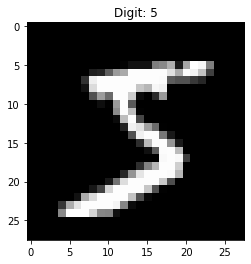

In [18]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

# Setup a Pipeline

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.75)

In [21]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x000001D98F6D4910>),
                ('Flatten Image',
                 <__main__.PipeStep object at 0x000001D98F6D48B0>),
                ('RF', RandomForestClassifier())])

In [12]:
!pip install lime

     -------------------------------------- 275.7/275.7 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283845 sha256=7b457fa339c183d7c9670fcc408596877461b93f69b50c3ad7b44948a0e3aba9
  Stored in directory: c:\users\ashuan\appdata\local\pip\cache\wheels\e6\a6\20\cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [22]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [23]:
%%time
explanation = explainer.explain_instance(X_test[0], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

Wall time: 10.8 s


Text(0.5, 1.0, 'Positive/Negative Regions for 1')

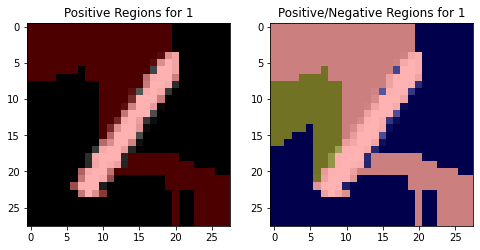

In [60]:
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test.iloc[0]))
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test.iloc[0]))

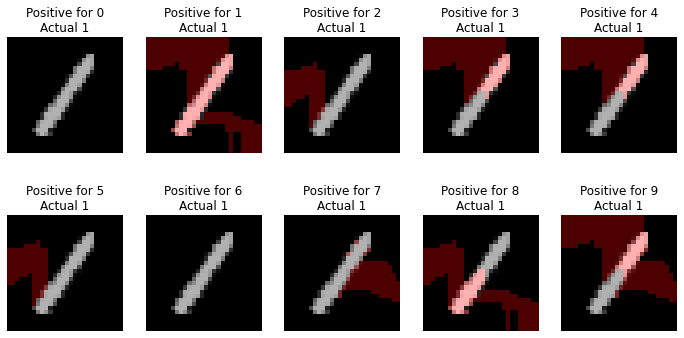

In [61]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[0]))
    c_ax.axis('off')

# bingquan: ignore below cells

## prediction confusion matrix

Accuracy on testing set =  0.9654285714285714


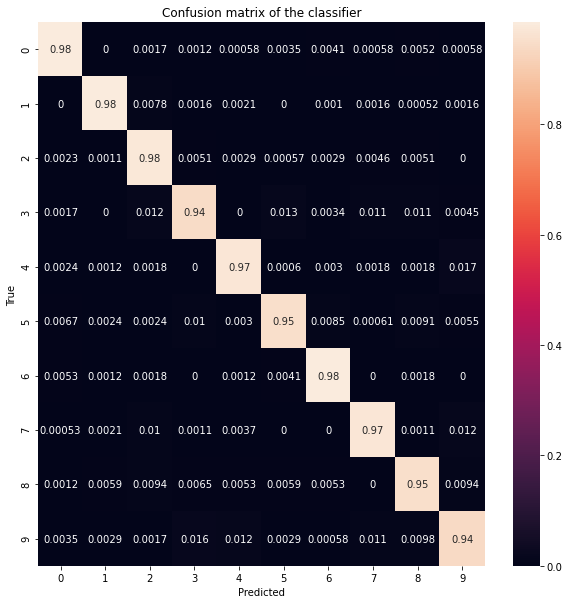

In [64]:
test_predictions = simple_rf_pipeline.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
print("Accuracy on testing set = ", accuracy_score(y_test, test_predictions))

cm = confusion_matrix(y_test, test_predictions, normalize='true')
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## a wrong example

In [73]:
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test.iloc[wrong_idx], pipe_pred_test[wrong_idx]))

Using #5083 where the label was 7 and the pipeline predicted 2


In [74]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

Wall time: 10.2 s


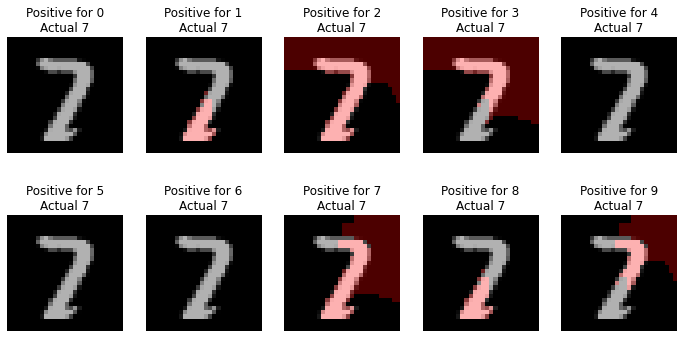

In [75]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[wrong_idx]))
    c_ax.axis('off')